# TACS Exam SS 23

<a target="_blank" href="https://colab.research.google.com/github/Timbertsen/ctoacs_exam/blob/main/exam_ss_23.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Organizational

The exam is carried out in 4 teams of 2 or 3 students each. The tasks are to classify images with 4 categories of objects:
1. **Lukas Heini & Isabel Fritz**
2. **Tim Albert & Philip Niemczyk**
3. **Joshua Schmitt & Milena Seifried**
4. **Lea Vidal, Mireia Vidal & Tim Weidemann**

The final report including the jupyter notebook(s) and the best performing saved model must be submitted by **June 19th, 2023, 23:59** at the latest.

The final report must be uploaded to Ilias.
The models (ZIP folder) can be uploaded to iRAS-Drive (inside VPN, link will be provided in ILIAS) or by providing a link to a private cloud storage (e.g. Google Drive, OnDrive, Dropbox, ...).

The final presentations will be held on **Wednesday, June 21th, 2023, 14:00 - 15:30**.

___

Group No.: 2

Student 1:
- Name: Philip Niemczyk
- Matriculation: *FILL IN*

Student 2:
- Name: Tim Albert
- Matriculation: 65050


___

### Tasks

Each team has already collected 400 images (200 online search, 200 created) for a single category.
A combined dataset has been created with 1300 training and 100 validation images and labels.
The images have been prepared to have **224 x 224 pixels** and **3 color channels** as np.float32 array with values between 0.0 and 255.0. The labels are tuples of 3 numpy arrays (inspect the datasets).

##### 1. Preparation

Prepare the image channels to be in the range of -1.0 and 1.0. Either apply the preparation to the <a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map">dataset</a> directly or use and adapted <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization#adapt">normalization layer</a> in your model.

##### 2. Model

Develop, train and evaluate deep multi-ouput neural networks for parallel class (classification), count (classification or regression) and location (regression of 4 floats) using the <a href="https://www.tensorflow.org/guide/keras/functional#manipulate_complex_graph_topologies">Functional API</a> (optionally in combination with <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Sequential</a> backbone). An example of a regression model can be found here: <a href="https://www.tensorflow.org/tutorials/keras/regression">Basic regression</a>.

Create **two** different models. The first model has the following restrictions:
For the first model, only use only Dense (at most 2, not regarding the final output layers), Conv2D (at most 4), MaxPooling2D, Flatten, Dropout (at most 1) layers. The second model has no restrictions.
    
Compare the trained neural networks regarding:
- reached accuracy
- required trainings steps
- observed overfitting

##### 3. Augmentation

Apply augmentation strategies to multiply the training data (not the test data!) using <a href="https://www.tensorflow.org/tutorials/images/data_augmentation#using_tfimage">tf.image</a> applied to the <a href="https://www.tensorflow.org/tutorials/images/data_augmentation#apply_augmentation_to_a_dataset">dataset</a>. Be careful when using augmentations such as crop, resize, move, and rotate as they require the labels (boxes) to be adjusted.

### Final report

Write a final report of approximatly 6 pages (3 pages per student) including plots.

The report should cover the following aspects:
- developed CNNs (including development process)
- training process and influence of augmentations
- own conclusions

________________________________________________

# Implementation and experiments

In [ ]:
!git clone https://github.com/Timbertsen/ctoacs_exam.git
# Pfad zu den Modulen im Repository in die Systempfade hinzufügen
import sys
sys.path.append('/content/ctoacs_exam/')

In [1]:
import tensorflow as tf
import numpy as np

import webbrowser
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import tempfile
import os
import pandas as pd 
import cv2
from IPython.display import display

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten,  MaxPooling2D, Concatenate
import tensorflow.keras.utils as keras_utils


import tacs_tools
import label_utils
import image_utils
import augmentation_utils

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# To Do

##### General
- [Done] Klassenname als Text auf die BBox schreiben (label_utils.draw_rect(test_image, test_bbox, label, classes))
- [] möglichst alle Listen in Arrays umwandeln


##### Augmentation
- [Done] gedrehte Bilder auf ursprüngliche Größe skalieren
- falls croppen, dann nur bis zur bbox
- Extra Datensatz der augmented Bilder erstellen 

##### Model

##### Training
- für Training beim ersten Durchlauf 0 Bilder von Augmented Data verwenden, beim Zweiten 650 Bilder (50% des Trainingsdatensatzes), beim Dritten 1300 Bilder und beim Vierten 2600 Bilder
- Versuchsplanungen

##### Visualizations
- Confusion Matrix


#### Freiwillig
- Data Augmentation mit GAN
- Deployen (Streamlit -> Webcam Camera Input aufnehmen -> Tools real time Detection)


## Data

### Überblick des Datensatzes

##### Trainingsdatensatz:<br />
    -- Variablenname: dataset_train 
    -- Variabelentyp: TensorSliceDataset 
    -- image, label = next(dataset_train.as_numpy_iterator()) # to get the image and label
    -- image = 224x224
    -- image channels value 0 - 255
    -- label[0]-> Klassenindex
    -- label[1]-> Anzahl der Objekte auf Bild (max 8 objects in one image)
    -- label[2]-> Koordinaten der Bbox (x_min, y_min, x_max, y_max)
<br />

##### Validierungsdatensatz:<br />
    -- Variablenname: dataset_train
    -- Variabelentyp: TensorSliceDataset
    -- image, label = next(dataset_train.as_numpy_iterator()) # to get the image and label
    -- image = 224x224
    -- image channels value 0 - 255
    -- label[0]-> Klassenindex
    -- label[1]-> Anzahl der Objekte auf Bild
    -- label[2]-> Koordinaten der Bbox (x_min, y_min, x_max, y_max)


In [2]:
classes = ["hammer",
           "pliers",
           "screwdriver",
           "wrench"]

image_size = (224, 224, 3)


cx = image_size[1]/2
cy = image_size[0]/2
h = image_size[0]
w = image_size[1]


# Load the prepared datasets

dataset_train, dataset_val = tacs_tools.load_datasets()

In [3]:
dataset_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)))>

In [3]:
lst_dataset_train=tacs_tools.tensorslicedataset_2_list(dataset_train)
lst_dataset_val=tacs_tools.tensorslicedataset_2_list(dataset_val)
combined_dataset = tacs_tools.tensorslicedataset_2_list(dataset_train.concatenate(dataset_val))

max_objects=0
for data in combined_dataset:
    if max_objects<data[1][1]:
        max_objects=data[1][1]

print(f"maximale Anzahl Objekte auf einem Bild sind: {max_objects}")

maximale Anzahl Objekte auf einem Bild sind: 8


In [4]:
print("Is each class represented equally?\n")
print("-------- Trainingsdatensatz --------")
tacs_tools.create_class_balance_table(lst_dataset_train, max_objects, classes)
print("-------- Validierungsdatensatz --------")
tacs_tools.create_class_balance_table(lst_dataset_val, max_objects, classes)

Is each class represented equally?

-------- Trainingsdatensatz --------
           hammer  pliers  screwdriver  wrench
1 objects     230     198          233     222
2 objects      57      86           57      64
3 objects      35      36           35      33
4 objects       2       3            0       5
5 objects       1       1            0       0
6 objects       0       0            0       1
7 objects       0       0            0       0
8 objects       0       1            0       0
Total         325     325          325     325
-------- Validierungsdatensatz --------
           hammer  pliers  screwdriver  wrench
1 objects      19      16           18      22
2 objects       5       8            5       2
3 objects       1       1            2       1
4 objects       0       0            0       0
5 objects       0       0            0       0
6 objects       0       0            0       0
7 objects       0       0            0       0
8 objects       0       0            0   

[0.26860118 0.32316467 0.6453373  0.6081349 ]
2 x 1 [Pliers]


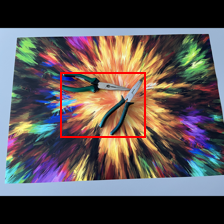

(1, 2, array([0.26860118, 0.32316467, 0.6453373 , 0.6081349 ], dtype=float32))
Klasse ist Pliers


In [5]:
image, label = next(dataset_train.as_numpy_iterator())

tacs_tools.show_labeled_image(image, label, classes)

print(label)


if tacs_tools.is_one_hot(label[0]):
    index = np.argmax(label[0])
else:
    index = label[0]

name = label_utils.get_label_name(label, classes)

print(f"Klasse ist {name}")

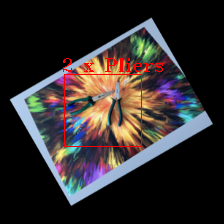

In [20]:
test_image, test_bbox = augmentation_utils.rotate_image_and_label(image, label)
tf.keras.utils.array_to_img(label_utils.draw_rect(test_image, test_bbox,label, classes))

In [4]:
image_utils.print_image_channels_range(combined_dataset)

Minimum pixel value: tf.Tensor(0.0, shape=(), dtype=float32)
Maximum pixel value: tf.Tensor(255.0, shape=(), dtype=float32)


In [6]:
# Add your code for preparation here ...
# Define a function to preprocess the image channels
def preprocess_image(image, label):
    # Convert the image data type to float32
    #image = tf.cast(image, tf.float32)
    
    # Normalize the image channels to the range [-1.0, 1.0]
    image = (image / 255.0) * 2.0 - 1.0
    
    # Convert label to one-hot
    one_hot_classes = tf.one_hot(label[0], depth=len(classes))
    new_label = (one_hot_classes, label[1], label[2])

    return image, new_label


# Apply preparation mapping

dataset_train = dataset_train.map(preprocess_image)
dataset_val = dataset_val.map(preprocess_image)

In [6]:
image_utils.print_image_channels_range(tacs_tools.tensorslicedataset_2_list(dataset_train.concatenate(dataset_val)))

Minimum pixel value: tf.Tensor(-1.0, shape=(), dtype=float32)
Maximum pixel value: tf.Tensor(1.0, shape=(), dtype=float32)


corners: [ 60.166664  72.388885 144.55556   72.388885 144.55556  136.22223
  60.166664 136.22223 ]
rotated corners [164.65385  222.89577  106.841385 161.42053  153.3424   117.690094
 211.15488  179.16533 ]
enclosed_rotated_corners [106.841385 117.690094 211.15488  222.89577 ]
rotated_bbox = [106.841385 117.690094 211.15488  222.89577 ]
resized_box [ 75.735664  83.42589  149.67941  158.00206 ]
new label (1, 2, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.33810565, 0.372437  , 0.66821164, 0.7053663 ], dtype=float32)>)
(1, 2, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.33810565, 0.372437  , 0.66821164, 0.7053663 ], dtype=float32)>)
tf.Tensor([0.33810565 0.372437   0.66821164 0.7053663 ], shape=(4,), dtype=float32)
2 x 1 [Pliers]
[0.26860118 0.32316467 0.6453373  0.6081349 ]
2 x 1 [Pliers]
[0.26860118 0.32316467 0.6453373  0.6081349 ]
2 x 1 [Pliers]
[0.26860118 0.32316467 0.6453373  0.6081349 ]
2 x 1 [Pliers]
<dtype: 'float32'>
<dtype: 'float32'>
<dtype: 'float32'>
<dtyp

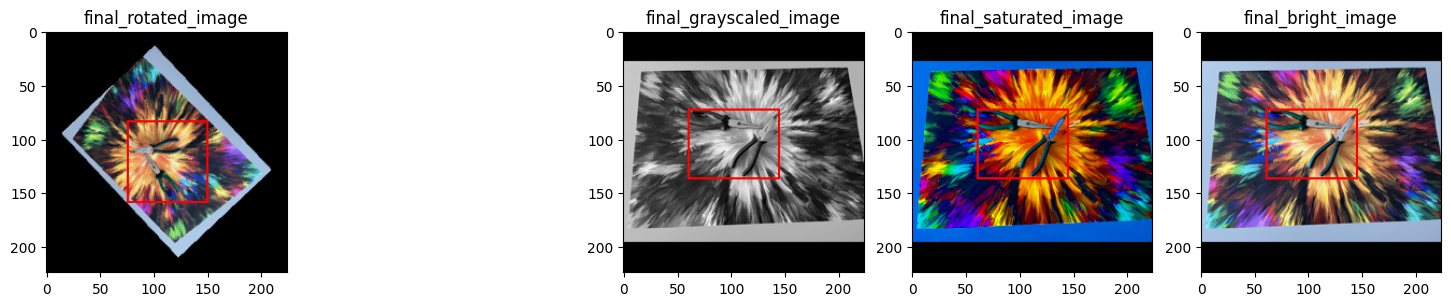

In [4]:
rotated_image, rotated_label = augmentation_utils.rotate_randomly_image_and_label(image, label)
#flipped_image, flipped_label = augmentation_utils.flip_image_label(image, label)
grayscaled_image, grayscaled_label = augmentation_utils.rgb_to_grayscale(image, label)
saturated_image, saturated_label = augmentation_utils.adjust_randomly_saturation(image, label)
bright_image, bright_label  = augmentation_utils.adjust_randomly_brightness(image, label)

print(rotated_label)
final_rotated_image = tacs_tools.show_labeled_image(rotated_image, rotated_label, classes, bool_display=False)
#final_flipped_image = tacs_tools.show_labeled_image(flipped_image, flipped_label, classes, bool_display=False)
final_grayscaled_image = tacs_tools.show_labeled_image(grayscaled_image, grayscaled_label, classes, bool_display=False)
final_saturated_image = tacs_tools.show_labeled_image(saturated_image, saturated_label, classes, bool_display=False)
final_bright_image = tacs_tools.show_labeled_image(bright_image, bright_label, classes, bool_display=False)

fig = plt.figure()
plt.figure
fig.set_size_inches(18, 6)
plt.subplot(1,5,1)
plt.title('final_rotated_image')
plt.imshow(final_rotated_image)

"""plt.subplot(1,5,2)
plt.title('final_flipped_image')
plt.imshow(final_flipped_image)"""

plt.subplot(1,5,3)
plt.title('final_grayscaled_image')
plt.imshow(final_grayscaled_image)

plt.subplot(1,5,4)
plt.title('final_saturated_image')
plt.imshow(final_saturated_image)

plt.subplot(1,5,5)
plt.title('final_bright_image')
plt.imshow(final_bright_image)

print(f"{rotated_image.dtype}")
#print(f"{flipped_image.dtype}")
print(f"{grayscaled_image.dtype}")
print(f"{saturated_image.dtype}")
print(f"{bright_image.dtype}")

In [4]:
import random 
import time
# Add your code for augmentation here ...
augmentation_procedures = [
    augmentation_utils.rotate_randomly_image_and_label,
    #augmentation_utils.flip_image_label,
    augmentation_utils.rgb_to_grayscale, # not real grayscale, the image has stil 3 channels 
    augmentation_utils.adjust_randomly_saturation,
    augmentation_utils.adjust_randomly_brightness  
]

def augment_data(image, label):
    # Define probabilities for each augmentation
    p_rotate = tf.random.uniform([], 0, 1)
    p_flip = tf.random.uniform([], 0, 1)
    p_gray = tf.random.uniform([], 0, 1)
    p_saturation = tf.random.uniform([], 0, 1)
    p_brightness = tf.random.uniform([], 0, 1)
    
    # Apply each augmentation with the defined probability
    if p_rotate > 0.5:
        image, label = augmentation_utils.rotate_randomly_image_and_label(image, label)
    #if p_flip > 0.5:
    #    image, label = tf.py_function(func=augmentation_utils.flip_image_label, inp=[image, label], Tout=[tf.float32, label.dtype])
    if p_gray > 0.65:
        image, label = augmentation_utils.rgb_to_grayscale(image, label)
    if p_saturation > 0.5:
        image, label = augmentation_utils.adjust_randomly_saturation(image, label)
    if p_brightness > 0.5:
        image, label = augmentation_utils.adjust_randomly_brightness(image, label)
    # ein else einbauen, damit zu 100% eine Augmentation durchgeführt wird. 
        
    return image, label


# Apply augmentation mapping (only to train dataset)

dataset_train_augmented = dataset_train.map(augment_data)

corners: Tensor("cond/PartitionedCall:0", shape=(8,), dtype=float32)
rotated corners Tensor("cond/strided_slice_9:0", shape=(8,), dtype=float32)
enclosed_rotated_corners Tensor("cond/stack_1:0", shape=(4,), dtype=float32)
rotated_bbox = Tensor("cond/stack_1:0", shape=(4,), dtype=float32)
resized_box Tensor("cond/stack_2:0", shape=(4,), dtype=float32)
new label (<tf.Tensor 'args_1:0' shape=() dtype=uint8>, <tf.Tensor 'args_2:0' shape=() dtype=uint8>, <tf.Tensor 'cond/stack_3:0' shape=(4,) dtype=float32>)


In [11]:
dataset_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)))>

In [8]:
dataset_train_augmented

<MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)))>

[0.26860118 0.32316467 0.6453373  0.6081349 ]
2 x 1 [1]


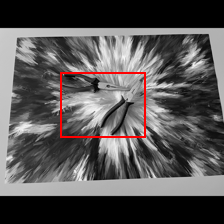

[0.36160713 0.25396827 0.7048611  0.48983136]
2 x 2 [2]


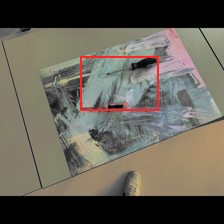

In [10]:
def display_images(dataset, num_images=2):
    dataset_iter = iter(dataset.as_numpy_iterator())

    for i in range(num_images):
        image, label = next(dataset_iter)
        tacs_tools.show_labeled_image(image, label)

# Now you can call this function to display the first five images and labels:
display_images(dataset_train_augmented)


2 x 1 [1]


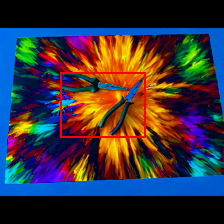

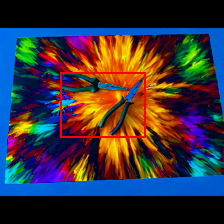

In [5]:
image, label = next(dataset_train_augmented.as_numpy_iterator())

tacs_tools.show_labeled_image(image, label)

In [36]:
image, label = next(iter(dataset_train_augmented))

image = image.numpy()
label = tuple(l.numpy() for l in label)

tacs_tools.show_labeled_image(image, label)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_4_device_/job:localhost/replica:0/task:0/device:CPU:0}} ValueError: not enough values to unpack (expected 4, got 2)
Traceback (most recent call last):

  File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Admin\AppData\Local\Temp\ipykernel_8568\1301069958.py", line 17, in augment_data_py
    image, label1, label2, label3 = augmentation_func(image, (label1, label2, label3))

ValueError: not enough values to unpack (expected 4, got 2)


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

## Inspection

alle oder ein Bild/ Label inspectieren

Image: 
Shape: (224, 224, 3)
dtype: float32
Range: min = -1.0, max = 1.0
Minimum pixel value: tf.Tensor(-1.0, shape=(), dtype=float32)
Maximum pixel value: tf.Tensor(1.0, shape=(), dtype=float32)
Range: min = -1.0, max = 1.0
Label: (array([0., 1., 0., 0.], dtype=float32), 2, array([0.26860118, 0.32316467, 0.6453373 , 0.6081349 ], dtype=float32))
Element 1:
  Shape: (4,)
  dtype: float32
  Range: min = 0.0, max = 1.0

Element 2:
  Shape: ()
  dtype: uint8
  Range: min = 2, max = 2

Element 3:
  Shape: (4,)
  dtype: float32
  Range: min = 0.2686011791229248, max = 0.6453372836112976

[0.26860118 0.32316467 0.6453373  0.6081349 ]
2 x 1 [1]


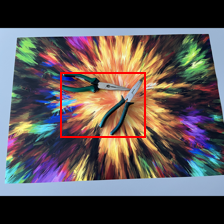

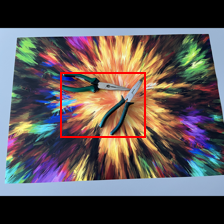

In [8]:
image, label = next(dataset_train.as_numpy_iterator())
#image, label = next(dataset_train_augmented.as_numpy_iterator())


# Print image and label properties (shape, dtype, range, ...)

# For the image
print(f"Image: ")
print(f"Shape: {image.shape}")
print(f"dtype: {image.dtype}")
print(f"Range: min = {image.min()}, max = {image.max()}")
image_utils.print_image_channels_range(tacs_tools.tensorslicedataset_2_list(dataset_train.concatenate(dataset_val)))
min_value, max_value = image_utils.get_images_channels_range(dataset_train.concatenate(dataset_val))
print(f"Range: min = {min_value}, max = {max_value}")


# For the label
print(f"Label: {label}")

for i, item in enumerate(label, start=1):
    print(f"Element {i}:")
    if hasattr(item, 'shape'): # If item has a 'shape' attribute
        print(f"  Shape: {item.shape}")
    if hasattr(item, 'dtype'): # If item has a 'dtype' attribute
        print(f"  dtype: {item.dtype}")
    if hasattr(item, 'min') and hasattr(item, 'max'): # If item has 'min' and 'max' methods
        print(f"  Range: min = {item.min()}, max = {item.max()}")
    else:
        print(f"  Value: {item}")
    print()


tacs_tools.show_labeled_image(image, label)

#min_value_class, max_value_class, min_value_count, max_value_count, min_x, min_y, max_x, max_y =label_utils.get_label_ranges(dataset_train.concatenate(dataset_val))
#print(f"{min_value_class}{max_value_class}{min_value_count}{max_value_count}{min_x}{min_y}{max_x}{max_y}")

# Run multiple times to test augmentation

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['conv2d[0][0]']                 
                                )                                                             

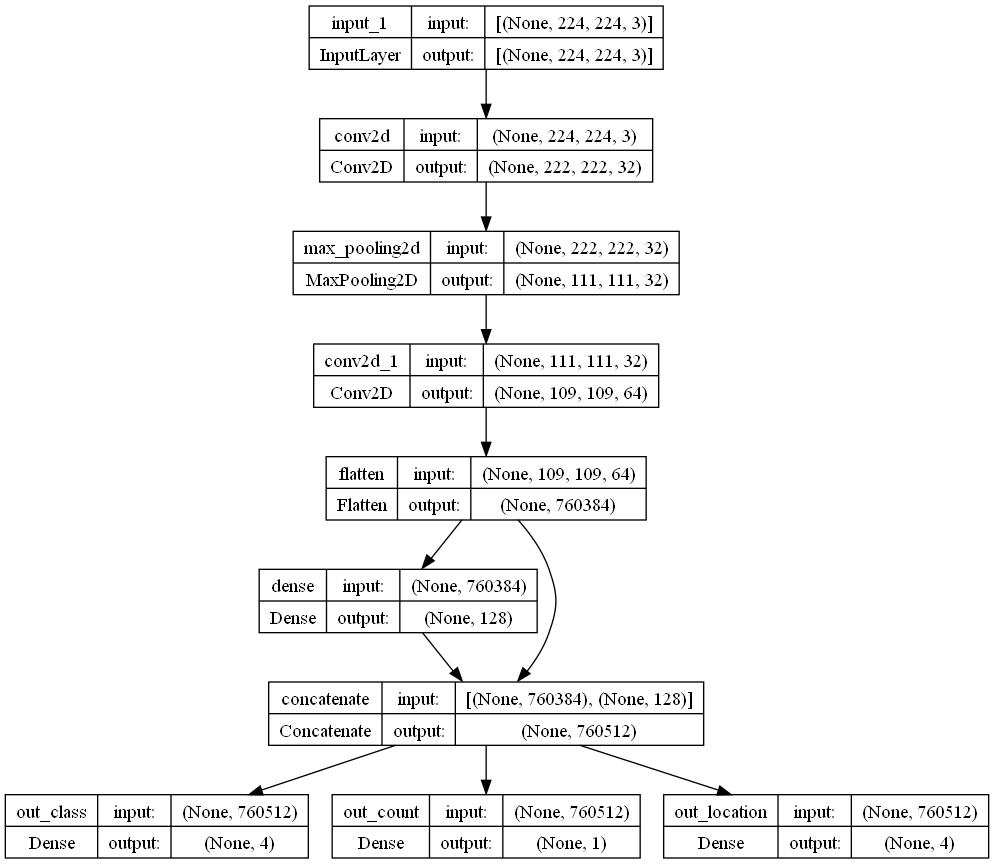

In [9]:
input = tf.keras.layers.Input(shape=image_size,
                              dtype=np.float32)

# Convolutional layers
conv_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input)
pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)

# Flattening layer
flat = tf.keras.layers.Flatten()(conv_2)

# Dense layer
dense_1 = tf.keras.layers.Dense(128, activation='relu')(flat)

# Merge all available features into a single large vector via concatenation
x = Concatenate()([flat, dense_1])


out_class = Dense(4, activation='softmax', name='out_class')(x)
out_count = Dense(1, activation='linear', dtype=np.uint8, name='out_count')(x)
out_location = Dense(4, name='out_location')(x)


# Build and compile the full model

model = tf.keras.Model(
    inputs=[input],
    outputs=[out_class, out_count, out_location],
)


model.compile(optimizer='adam',
              loss={'out_class': 'categorical_crossentropy', 'out_count': 'mean_squared_error', 'out_location': 'mean_squared_error'},
              metrics={'out_class': 'accuracy', 'out_count': 'mae', 'out_location': 'mae'})

training_history = {"meta": {"epochs": 0}}

#backbone.summary()
model.summary()

keras_utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

## Model

In [ ]:
import mlflow
mlflow.autolog()


input = tf.keras.layers.Input(shape=image_size,
                              dtype=np.float32)

# Optinally use Sequential for the backbone

backbone = tf.keras.Sequential([
    # Add your layers here...
])


# Or build the whole model using the Functional API

# Add your layers here...



# Create the output layers (always using the Functional API)

# Add your layers here...
# Output layers
out_class = Dense(num_classes, activation='softmax', name='out_class')(x)
out_count = Dense(1, name='out_count')(x)
out_location = Dense(4, name='out_location')(x)


# Build and compile the full model

model = tf.keras.Model(
    # Add your code here...
)

model.compile(
    # Add your code here...
)

training_history = {"meta": {"epochs": 0}}

backbone.summary()
model.summary()

keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)


## Training

In [11]:
# Create batched datasets
batch_size = 32

dataset_train_batch = dataset_train.batch(batch_size)
#dataset_train_batch = dataset_train_augmented.batch(batch_size)
dataset_val_batch = dataset_val.batch(batch_size)

Epoch 1/2
41/41 [==============================] - 107s 3s/step - loss: 309.8530 - out_class_loss: 6.7299 - out_count_loss: 174.1516 - out_location_loss: 128.9715 - out_class_accuracy: 0.2931 - out_count_mae: 6.1074 - out_location_mae: 4.5902 - val_loss: 3.2507 - val_out_class_loss: 1.3790 - val_out_count_loss: 1.6430 - val_out_location_loss: 0.2286 - val_out_class_accuracy: 0.3200 - val_out_count_mae: 1.1481 - val_out_location_mae: 0.3968
Epoch 2/2
41/41 [==============================] - 104s 3s/step - loss: 3.6886 - out_class_loss: 1.3500 - out_count_loss: 2.0982 - out_location_loss: 0.2404 - out_class_accuracy: 0.3900 - out_count_mae: 1.2317 - out_location_mae: 0.3937 - val_loss: 2.7667 - val_out_class_loss: 1.3558 - val_out_count_loss: 1.2268 - val_out_location_loss: 0.1841 - val_out_class_accuracy: 0.4300 - val_out_count_mae: 0.9332 - val_out_location_mae: 0.3449


c:\Users\Admin\Desktop\KI_Ressourcen\current_topics_of_applied_computer_science\ctoacs_project\ctoacs_project\new_project_directory\tacs_exam_ss_23\tacs_tools.py:303: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axes[index].set_ylim(ylim[index][0] - ylim_delta,


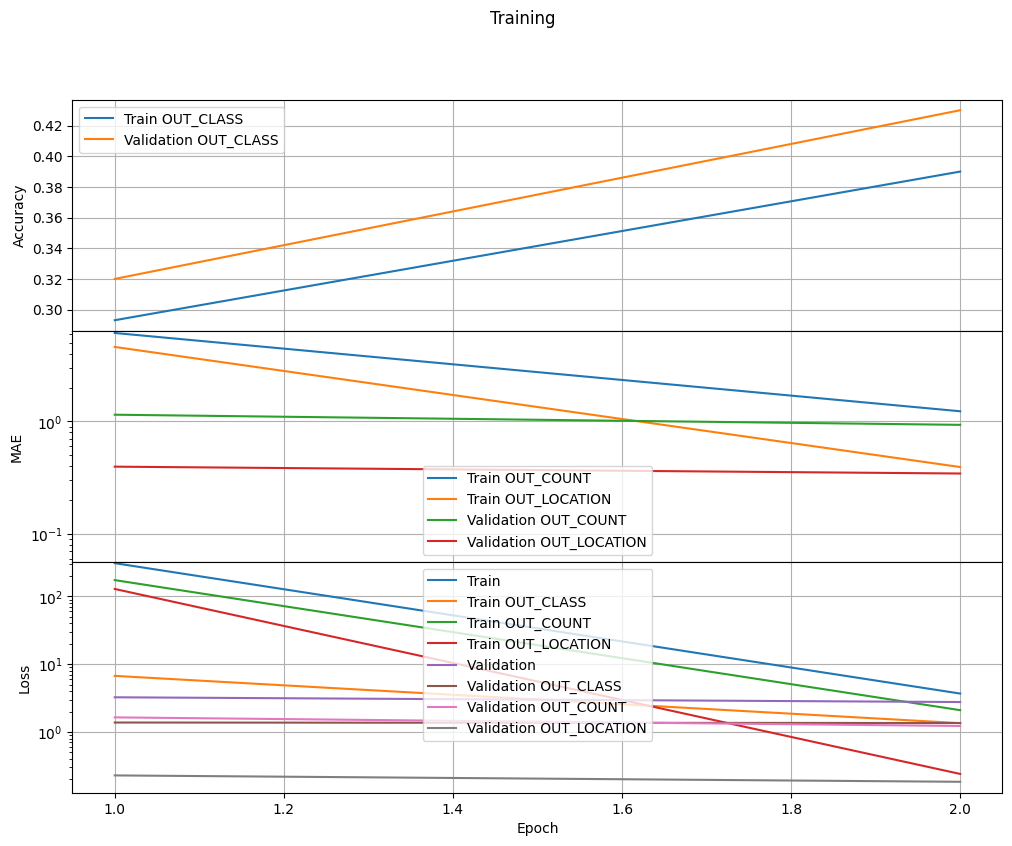

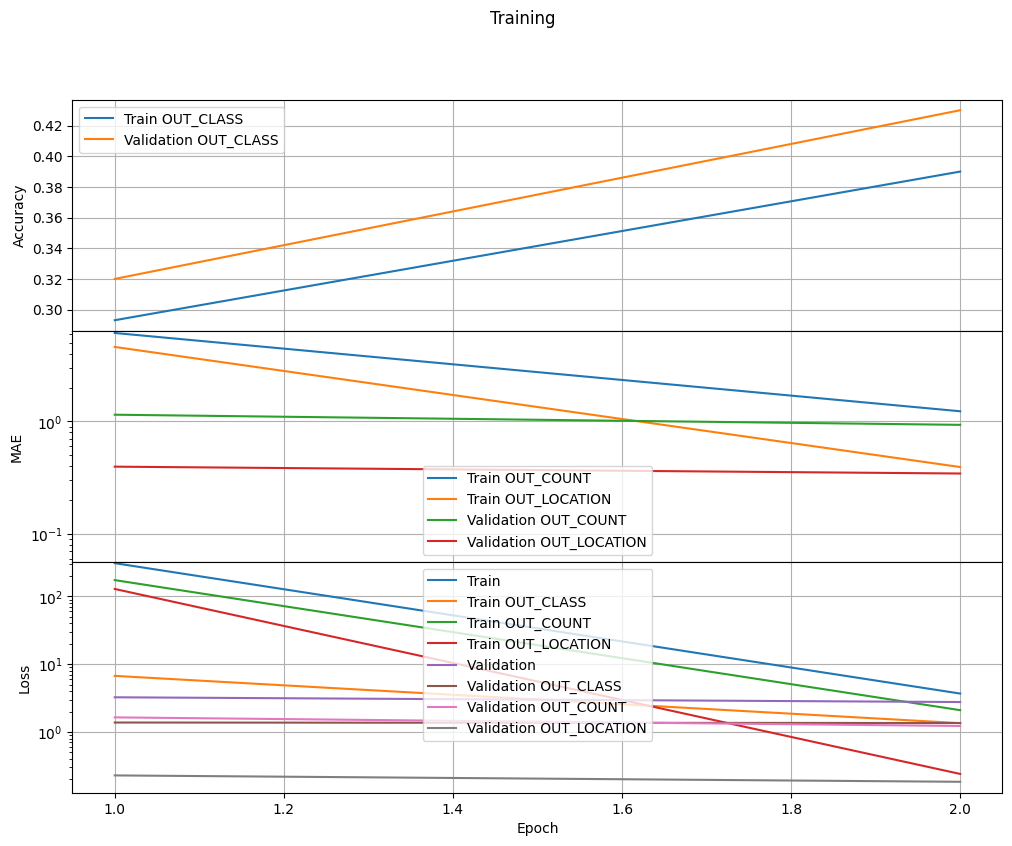

In [12]:
epochs = 2

history = model.fit(dataset_train_batch,
                    validation_data=dataset_val_batch,
                    epochs=epochs,
                    initial_epoch=training_history["meta"]["epochs"])

training_history["meta"]["epochs"] += len(history.epoch)

for key in history.history:
    for value in history.history[key]:
        if key not in training_history:
            training_history[key] = []

        training_history[key].append(value)
        
history = tacs_tools.plot_history(training_history)

## Evaluation and visualization

In [13]:
predictions = model.predict(dataset_val_batch)

4/4 [==============================] - 2s 376ms/step


Prediction:
[0.00998848 0.03962594 0.082835   0.06606241]
[0.11816063] x 3 (25.8%) [Wrench]


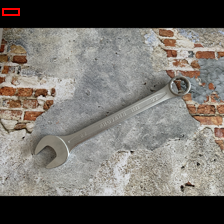

Label:
[0.15352182 0.33854166 0.84945434 0.7554563 ]
1 x 3 [Wrench]


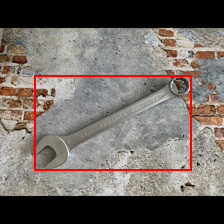

Prediction:
[0.04127877 0.09649596 0.20833936 0.18310975]
[0.33548084] x 2 (27.2%) [Screwdriver]


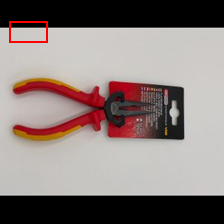

Label:
[0.05666667 0.34       0.70666665 0.63666666]
1 x 1 [Pliers]


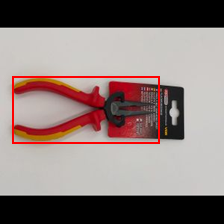

In [14]:
start_index = 2
count = 2

dataset = dataset_val.skip(start_index).take(count)

for index, (image, label) in enumerate(dataset.as_numpy_iterator()):
    print("Prediction:")
    tacs_tools.show_labeled_image(image,
                                  (predictions[0][index],
                                   predictions[1][index],
                                   predictions[2][index]),
                                  classes=classes)

    print("Label:")
    tacs_tools.show_labeled_image(image,
                                  label,
                                  classes=classes)

## Save

In [ ]:
tacs_tools.save_model_and_history(model,
                                  training_history)